# The Background Remover Function


- In the following code we will implement a function that removes the background (any thing except for clothes, bags and shoes) of an image using trained UNet model.<br>
- The function will take an image as an input and return the image with the background removed. <br>
- The function contains 'prob' parameter that is used to set the probability threshold for the mask, you can keep the default value which is "argmax" or to set a custom value for the mask probability threshold. <br>
- The "prob" parameter when is set to "argmax" that means the pixel will be assigned to the greater probability class (0: background, 1: foreground). <br>
- The probability threshold is used to determine the probability at which the mask will be applied to the image. <br>
- Example if the probability threshold is 0.7 then the mask will be all the pixels if their probability of the pixel to be a (class 1) foreground is equal or greater than 0.7 otherwise the mask will not be applied, or simply it will be assigned to be background(class 0). <br>
- Applying the mask to the image will remove the background of the image and keep the object in the image. <br>
- "enlarge" parameter is used to enlarge the result picture by a certain factor to make sure that the object is in full size in the picture boundaries (256 x 256 ) it has been set as a default value to be TRUE. <br>
- "Kernel" parameter is used to set the kernel size of the morphological operation that is used to remove the noise from the mask, it has been set as a default value to be 3. <br>

In [1]:
# import the necessary packages
import cv2
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

## Define the main function of the background Remover

In [20]:

def remove_background(image_path, model, prob="argmax", kernel_size=7,enlarge=True):

    # Read the image path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)

    # Preprocess the image
    # Pad the image to make it square
    shape = tf.shape(img)
    height, width = shape[0], shape[1]
    max_dim = tf.maximum(height, width)
    pad_height = (max_dim - height) // 2
    pad_width = (max_dim - width) // 2
    padding = [[pad_height, max_dim - height - pad_height],
               [pad_width, max_dim - width - pad_width],
               [0, 0]]
    img = tf.pad(img, padding, mode='CONSTANT', constant_values=255)
    img = tf.image.resize(img, [256, 256])
    img = img / 255.0
    img = tf.expand_dims(img, 0)

    # Predict the mask
    pred_mask = model.predict(img)

    if prob == "argmax":
        mask = tf.math.argmax(pred_mask, axis=-1)
        mask = tf.cast(mask, tf.uint8)
        mask = tf.squeeze(mask, axis=0)
    else:
        mask = tf.math.softmax(pred_mask, axis=-1)
        mask = mask[..., 1]
        mask = tf.math.greater_equal(mask, prob)
        mask = tf.cast(mask, tf.uint8)
        mask = tf.squeeze(mask, axis=0)

    # Reduce noise using morphological operations
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    mask = cv2.morphologyEx(mask.numpy(), cv2.MORPH_CLOSE, kernel)  # Closing to remove small holes
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Keep the pixels in the main image that are in the mask with class 0 other than give it 1 (white) (255/255 = 1)
    img = tf.squeeze(img, axis=0)
    mask_3d = tf.stack([mask] * 3, axis=-1)
    img = tf.where(mask_3d == 0, img, 1.0)
    img = tf.cast(img * 255, tf.uint8)

    if enlarge:
        # find the boundries
        coords = np.column_stack(np.where(mask == 0))
        top_left = coords.min(axis=0)
        bottom_right = coords.max(axis=0)

        height =bottom_right[0]-top_left[0]
        width =bottom_right[1]-top_left[1]

        max_dim = tf.maximum(height, width)
        pad_height = (max_dim - height) // 2
        pad_width = (max_dim - width) // 2

        # find the center of the image
        center = (top_left+bottom_right)//2
        img_croped = img[center[0]-height//2:center[0]+height//2 , center[1]-width//2:center[1]+width//2]
        
        # pad the croped image to the square
        img = tf.pad(img_croped, [[pad_height, max_dim - height - pad_height],[pad_width, max_dim - width - pad_width],[0, 0]], mode='CONSTANT', constant_values=255)
        img = tf.image.resize(img, [256, 256])
        img = tf.cast(img , tf.uint8)

    return img 



### Import the model 

In [3]:
# import the model 
model = tf.keras.models.load_model("unet_model_final_full.keras")


### Try the model 

### In the following test I have tried the enlargement option, argmax and the probability threshold option just to show how the function works.

In [4]:
# find the links of the images

directory = r"**************************************************" # directory where the test images are located
links = []
for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    # Check if it's a file before adding to the list
    if os.path.isfile(filepath):
        links.append(filepath)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step


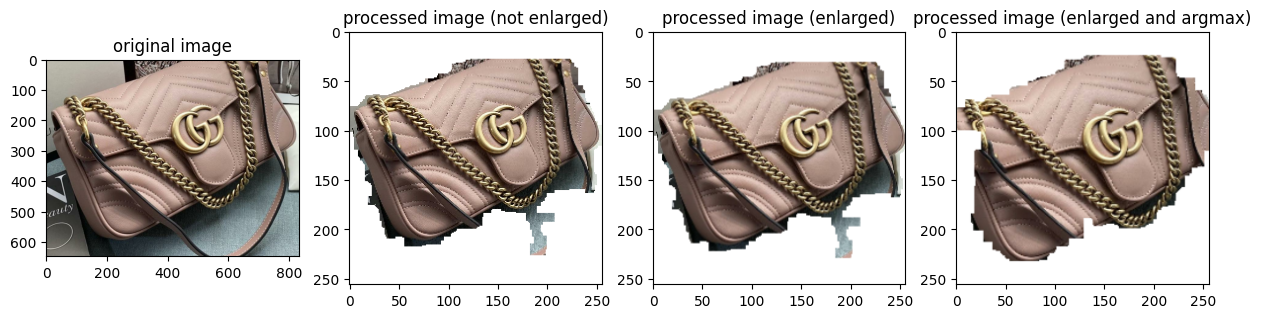

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step


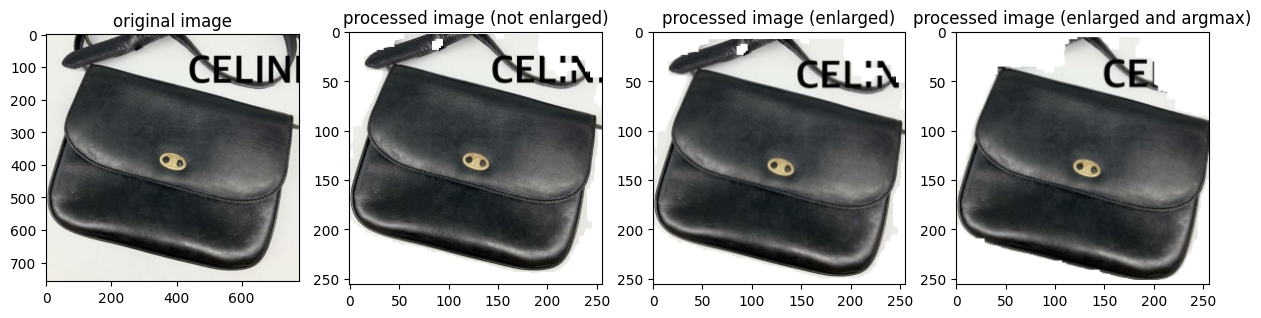

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


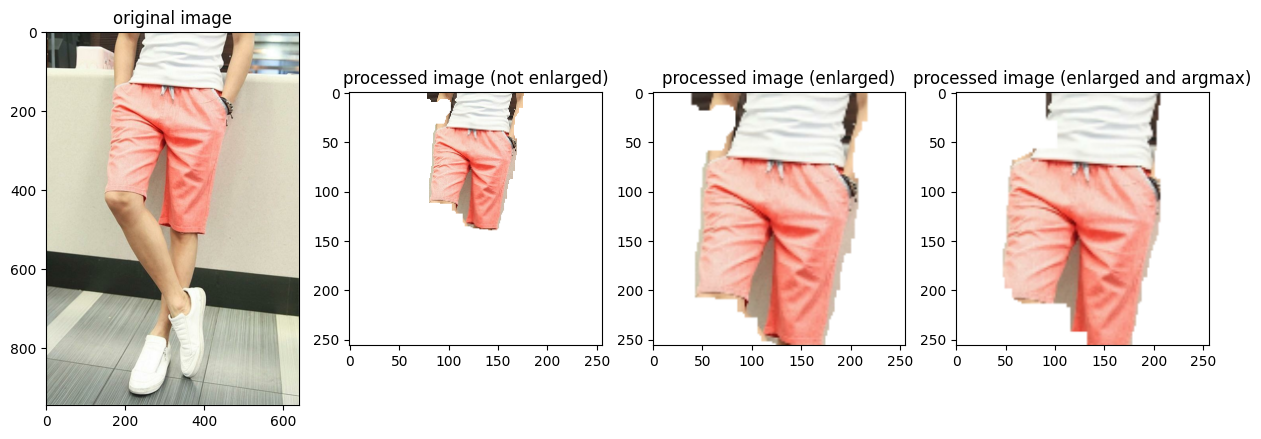

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step


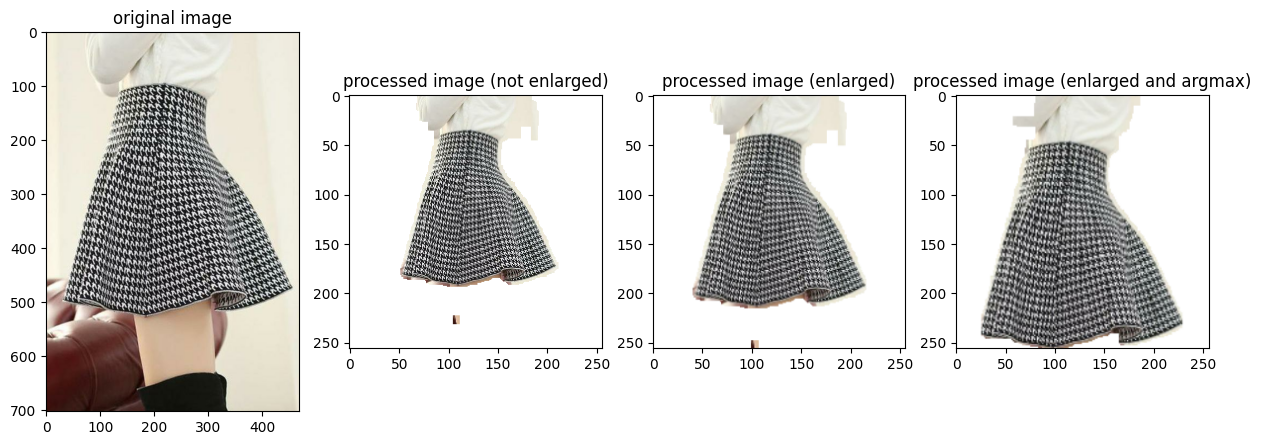

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


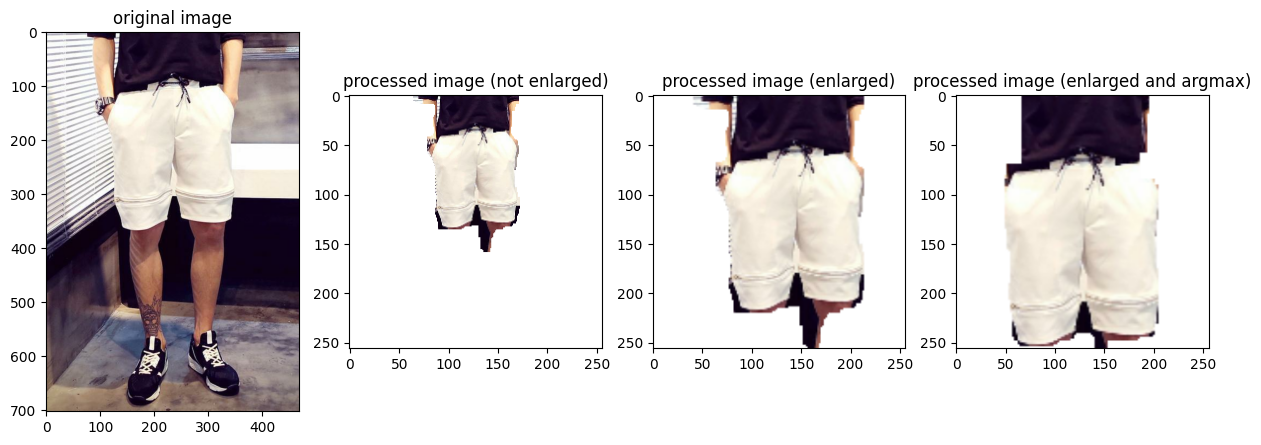

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step


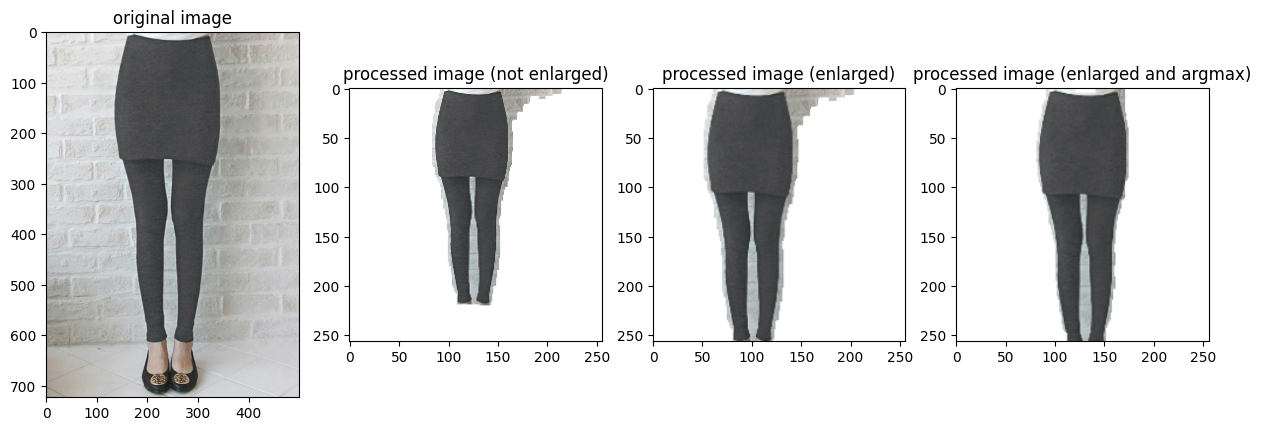

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step


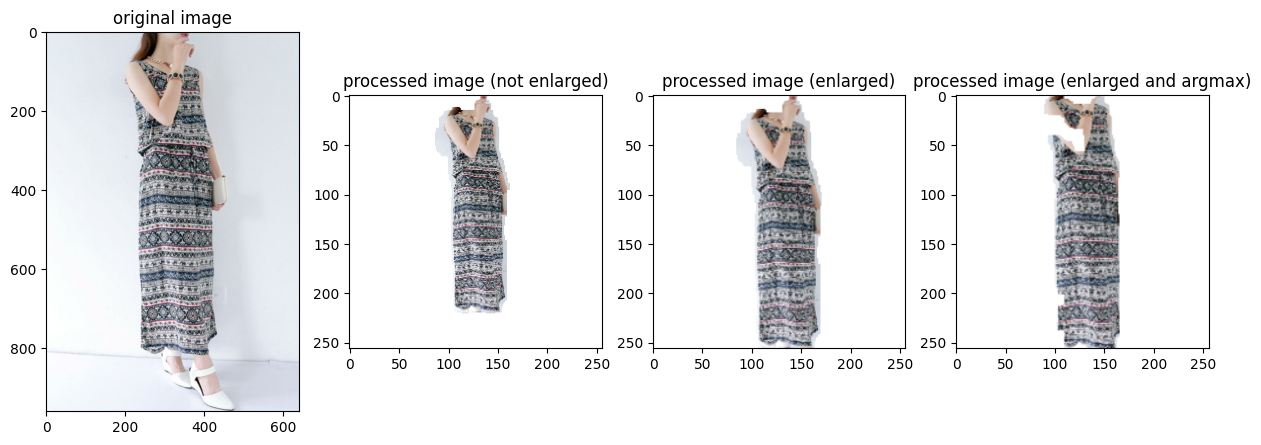

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step


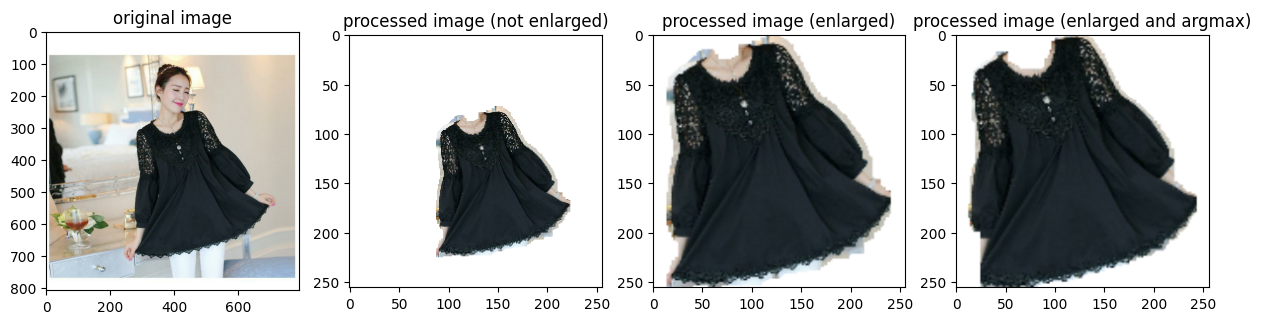

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step


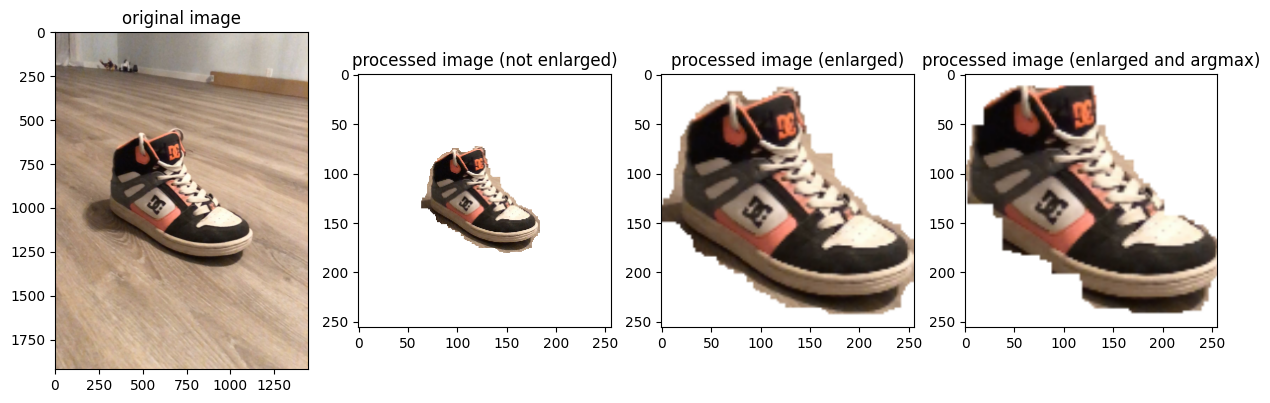

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


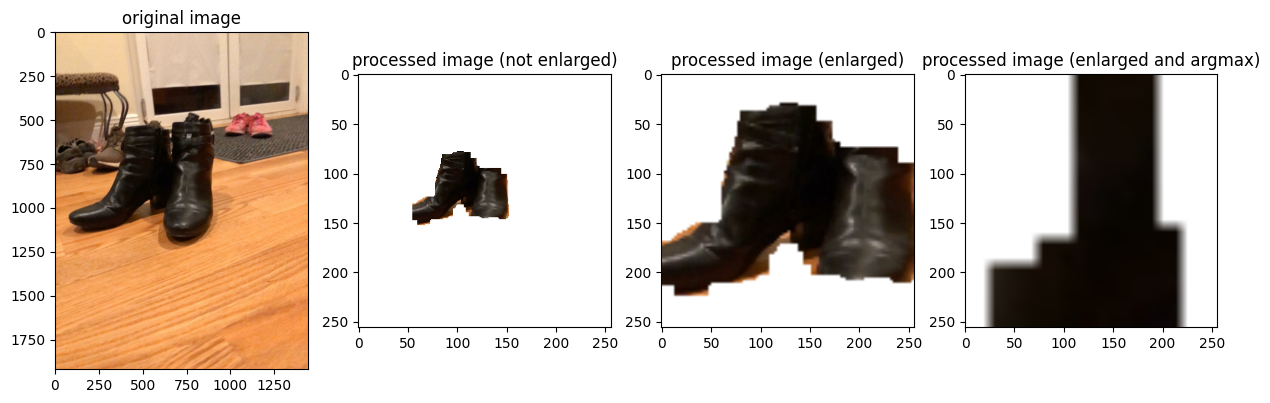

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


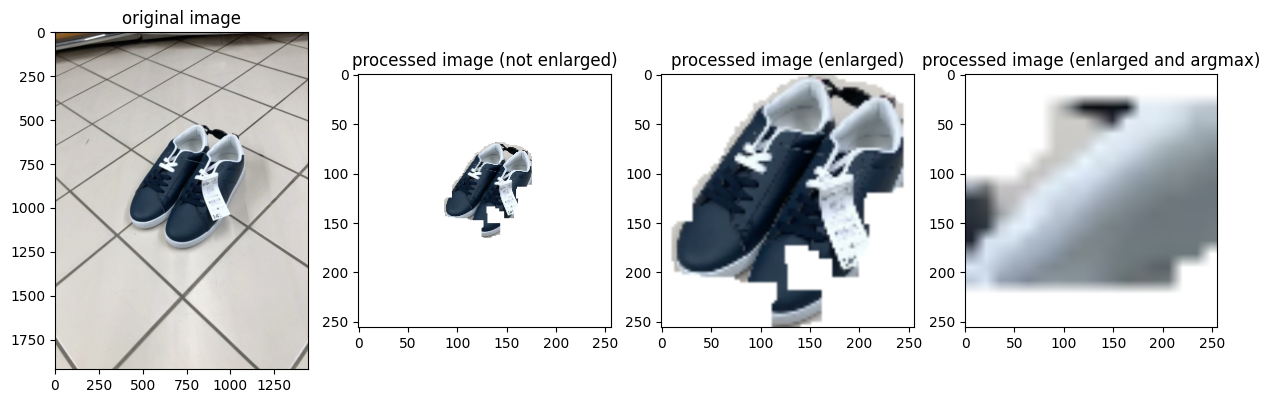

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step


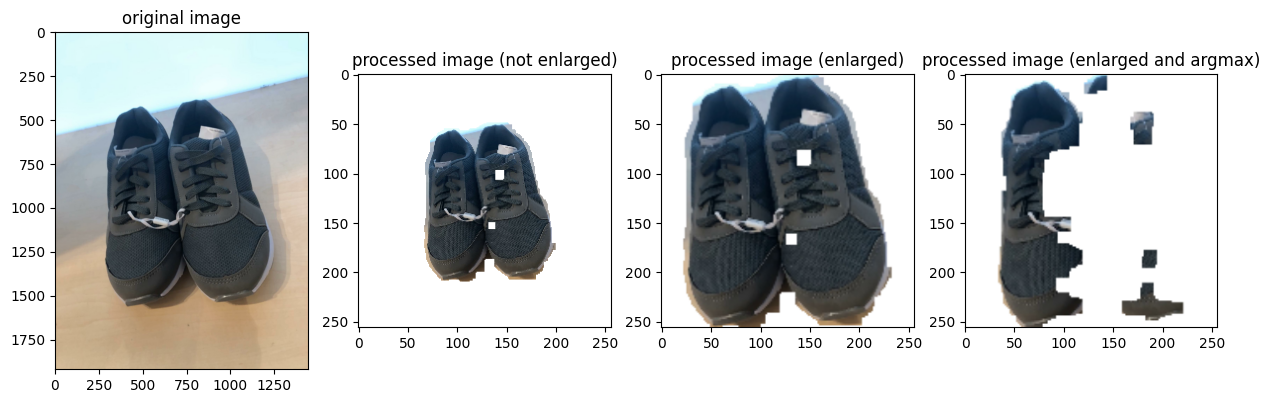

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


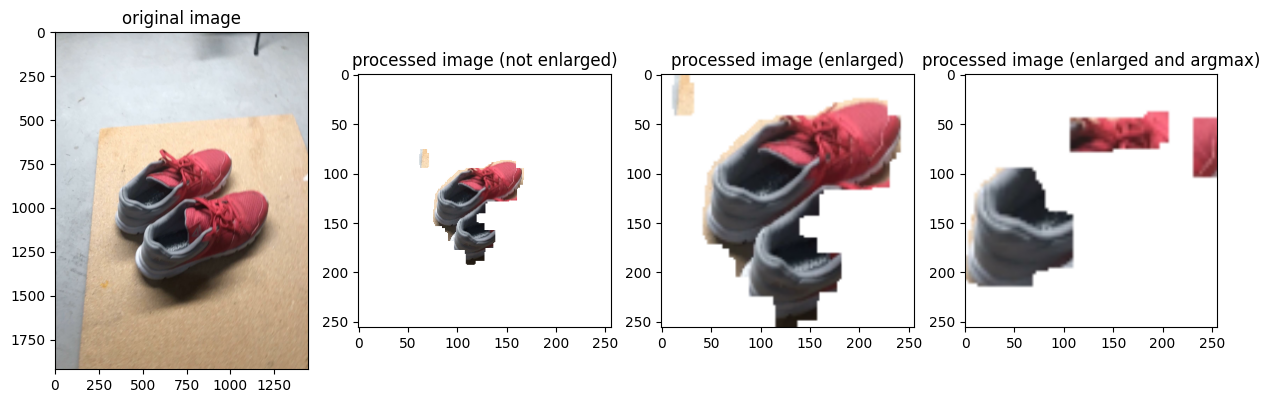

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step


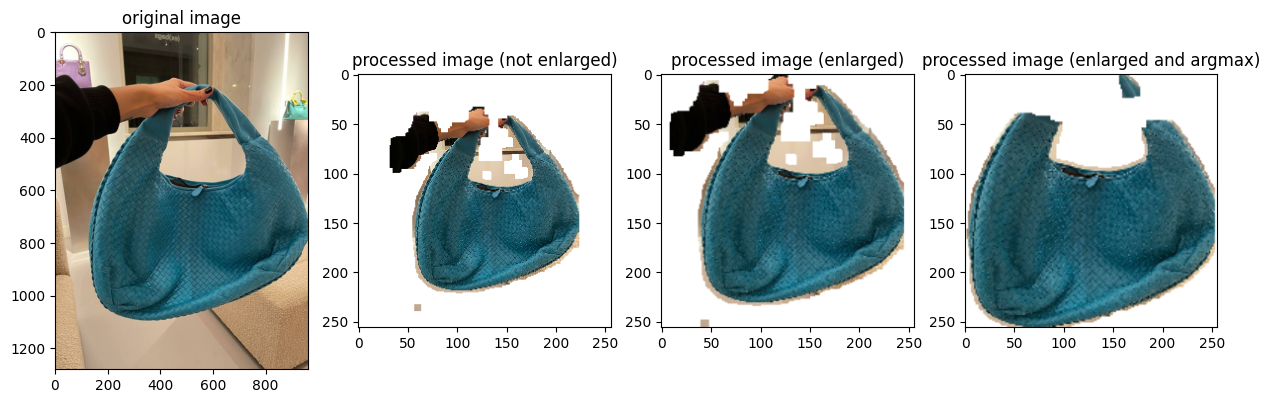

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step


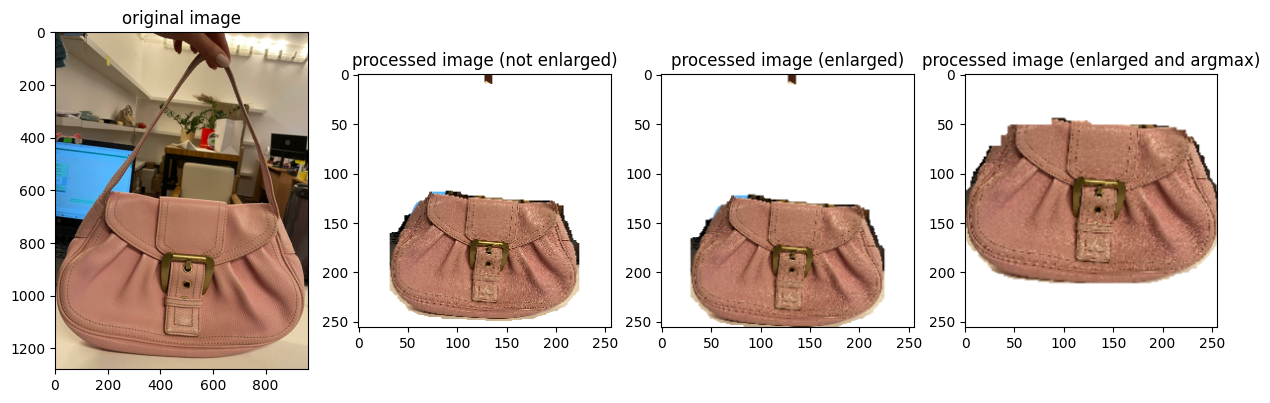

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step


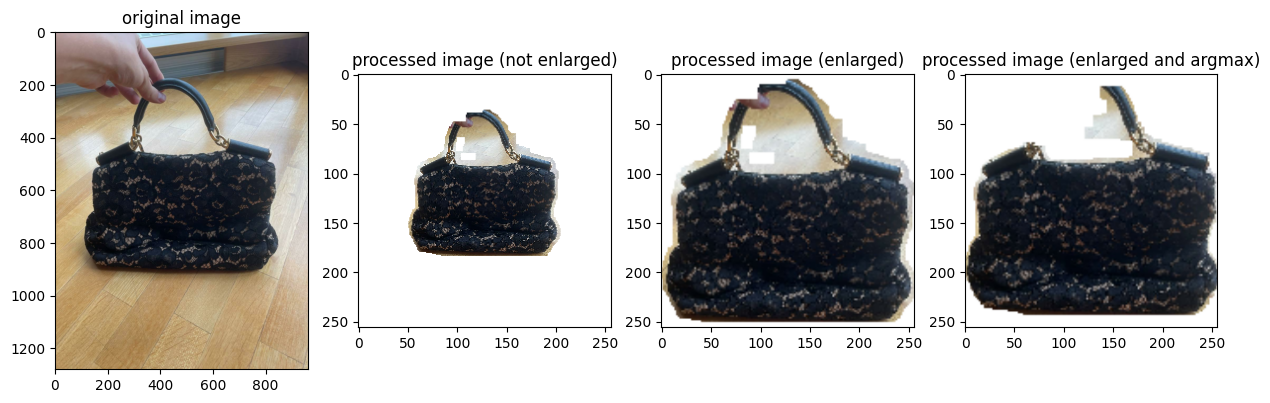

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


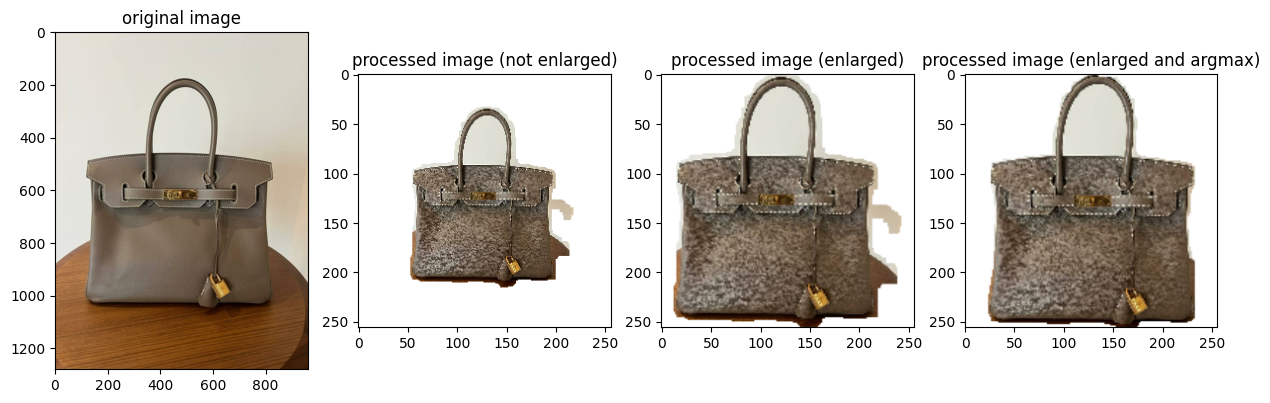

In [24]:
# Load and preprocess a sample image
for i in links:

    sample_image = i

    # dispaly the original sample_image
    original_img = tf.io.read_file(sample_image)
    original_img = tf.image.decode_jpeg(original_img, channels=3)

    # the image with the background removed and enlaged
    img_enlaged= remove_background(sample_image, model , prob=0.9 , kernel_size=7 ,enlarge=True)

    # the image with the background removed and not enlaged
    img_not_enlaged= remove_background(sample_image, model , prob=0.9 , kernel_size=7 ,enlarge=False)

    # the image with the background removed and enlarged and argmax
    img_enlaged_argmax= remove_background(sample_image, model , prob="argmax" , kernel_size=7 ,enlarge=True)


    plt.figure(figsize=(15, 15))
    plt.subplot(1, 4, 1)
    plt.imshow(original_img)
    plt.title("original image")
    plt.subplot(1, 4, 2)
    plt.imshow(img_not_enlaged)
    plt.title("processed image (not enlarged)")
    plt.subplot(1, 4, 3)
    plt.imshow(img_enlaged)
    plt.title("processed image (enlarged)")
    plt.subplot(1, 4, 4)
    plt.imshow(img_enlaged_argmax)
    plt.title("processed image (enlarged and argmax)")
    plt.show()

